In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import log_loss
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train_set = pd.read_csv('train_prepared.csv', encoding='utf-8')
test_set = pd.read_csv('test_prepared.csv', encoding='utf-8')

In [3]:
X = train_set.drop(columns=['Target', 'Opportunity_ID'])
y = train_set.Target

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
#def objective(space):

    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
#    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
#                            max_depth = int(space['max_depth']),
#                            learning_rate = space['learning_rate'],
#                            gamma = space['gamma'],
#                            min_child_weight = space['min_child_weight'],
#                            subsample = space['subsample'],
#                            colsample_bytree = space['colsample_bytree']
#                            )
    
#    classifier.fit(X_train, y_train)

    # Applying k-Fold Cross Validation
#    from sklearn.model_selection import cross_val_score
#    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
#    CrossValMean = accuracies.mean()

#    loss = log_loss(y_test, classifier.predict_proba(X_test))
    
#    print("-----------------")
#    print("log_loss:", loss)
#    print("CV mean:", CrossValMean)
#    print("-----------------")

#    return{'loss':loss, 'status': STATUS_OK }

#space = {
#    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
#    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
#    'n_estimators' : hp.choice('n_estimators', range(20, 250, 5)),
#    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
#    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
#    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
#    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

#trials = Trials()
#best = fmin(fn=objective,
#            space=space,
#            algo=tpe.suggest,
#            max_evals=250,
#            trials=trials)

#print("Best: ", best)

In [6]:
best = {'colsample_bytree': 0.84, 
        'gamma': 0.49, 'learning_rate': 0.05, 'max_depth': 23,
        'min_child_weight': 6.0, 'n_estimators': 50, 'subsample': 0.84}

In [7]:
final = xgb.XGBClassifier(**best)

In [8]:
final.fit(X_train, y_train)

C:\Users\renzo\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.84, gamma=0.49, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=23,
              min_child_weight=6.0, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.84,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
preds_x = final.predict_proba(X_test)

In [10]:
from sklearn.metrics import f1_score

In [11]:
print(log_loss(y_train, final.predict_proba(X_train)))
f1_score(y_train, final.predict(X_train))

0.24098760019457802


0.936662157176239

In [12]:
print(log_loss(y_test, preds_x))
f1_score(y_test, final.predict(X_test))

0.33528928157867305


0.8668582375478928

In [13]:
test_preds = final.predict_proba(test_set.drop(columns=['Opportunity_ID', 'Target']))

In [15]:
print(log_loss(test_set.Target, test_preds))
f1_score(test_set.Target, final.predict(test_set.drop(columns=['Target', 'Opportunity_ID'])))

0.4674716130488605


0.7833026396562307

In [17]:
preds = pd.DataFrame(test_preds[:, 1])
preds['Opportunity_ID'] = test_set.Opportunity_ID.to_list()
preds['Real'] = test_set.Target.to_list()

In [18]:
sub = preds.loc[:, ['Opportunity_ID', 0]]
sub.columns = ['Opportunity_ID', 'Target']
sub

,Opportunity_ID,Target
0,10689,0.887558
1,10690,0.642636
2,10691,0.434558
3,10692,0.250382
4,10693,0.913990
...,...,...
1562,12364,0.944161
1563,12365,0.230195
1564,12366,0.224918
1565,12367,0.377928


In [19]:
sub.to_csv('predictions/xgb_hyperopt.csv', index=False)

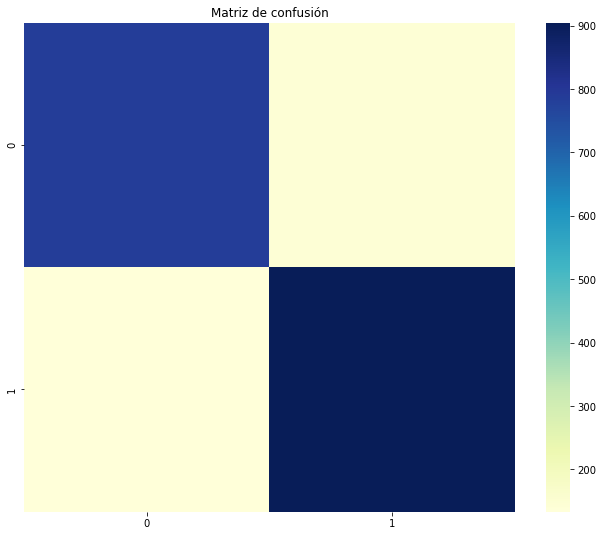

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))
plt.title('Matriz de confusión')
sns.heatmap(confusion_matrix(y_test, final.predict(X_test)), cmap='YlGnBu')
plt.show()